In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import glob
from scipy import stats
import pingouin as pg
import xarray as xr
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
import dataframe_image as dfi
import sys
sys.path.insert(0, '/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability')
import tool_box

colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)


def correlation_matrix_creator(predictors_and_target_df):
    predictors_and_target_df = predictors_and_target_df.to_numpy()
    corr_matrx = []
    for ts_1 in range(len(predictors_and_target_df.T)):
        corr_row = []
        for ts_2 in range(len(predictors_and_target_df.T)):
            timeseries_1 = predictors_and_target_df[:,ts_1]
            timeseries_2 = predictors_and_target_df[:,ts_2]
            N = len(timeseries_1)
            r = stats.pearsonr(timeseries_1[:], timeseries_2[:])[0]
            r1_autocorrelation = stats.pearsonr(timeseries_1[1:], timeseries_1[:-1])[0]
            r2_autocorrelation = stats.pearsonr(timeseries_2[1:], timeseries_2[:-1])[0]
            N_star = N*((1-r1_autocorrelation*r2_autocorrelation)/
                        (1+r1_autocorrelation*r2_autocorrelation))
            tcrit = stats.t.ppf(1-0.025, N_star)
            t = (r*np.sqrt(N_star - 2))/(np.sqrt(1 - r**2))
            if abs(t) - tcrit > 0:
                significant = 1
            else:
                significant = 0
            corr_row.append([r, significant])
        corr_matrx.append(corr_row)
    return np.array(corr_matrx)

def cf_profile_finder(cf_prof_maps):
    cf_prof_maps_ = np.sort(cf_prof_maps)
    profile_cf = np.array([np.load(cf_prof_maps_[yr])[0] for yr in range(len(cf_prof_maps_))])
    empty_prof_map = np.empty(np.shape(profile_cf[:5]))
    empty_prof_map[:] = np.NaN
    profile_cf = np.concatenate((empty_prof_map, profile_cf), axis=0)
    profile_cf = np.reshape(profile_cf, (15,12,24,144,221))
    profile_cf[10,1] = np.nanmean([profile_cf[10,0], profile_cf[10,2]], axis=0)
    profile_cf_anoms = profile_cf - np.nanmean(profile_cf, axis=0)
    profile_cf_anoms_zm = np.nanmean(np.reshape(profile_cf_anoms, (15,12,24*144,221)), axis=2)
    profile_cf_anoms_ts = np.reshape(profile_cf_anoms_zm, (180,221))[5:]
    return(profile_cf_anoms_ts)

def corr_matrix_plotter(corr_matrx):
    correlation_matrix = corr_matrx[:,:,0]
    correlation_matrix = np.around(correlation_matrix, 2)
    significance_matrix = corr_matrx[:,:,1] 

    # Significance will be dictated in Correlation Matrix with '*'
    sig_str = []
    for row in significance_matrix:
        row_str = []
        for item in row:
            if int(item) == 1:
                row_str.append('*')
            else:
                row_str.append(' ')
        sig_str.append(row_str)
    sig_str = np.array(sig_str)

    corr = correlation_matrix.astype(str)
    matrix = np.triu(np.ones_like(corr_matrx))
    plt.figure(figsize=(len(correlation_matrix),len(correlation_matrix)))
    sns.set_palette("Paired")
    sns.color_palette("Paired")
    # combining text with values
    formatted_text = (np.asarray(["{corr}{sig}".format(corr=corr[:5], sig=sig) for corr, sig in zip(corr.flatten(), sig_str.flatten())])).reshape(len(correlation_matrix), len(correlation_matrix))
    #formatted_text = (print(np.asarray(["{corr}\n{sig}".format(corr=corr[:5], sig=sig) for corr, sig in zip(corr.flatten(), sig_str.flatten())]))).reshape(8, 8)
    # plot the heatmap
    matrix = np.triu(np.ones_like(significance_matrix))
    ax = sns.heatmap(correlation_matrix, xticklabels=predictors_and_target_df.columns, 
                yticklabels=predictors_and_target_df.columns, cmap=custom_cmap, 
                annot=formatted_text,  vmin=-1, vmax=1, fmt="",
                annot_kws={"fontsize":12}, mask=matrix, cbar=False)
    for i in range(0, len(matrix)-1):
        for j in range(1, len(matrix[i])):
            if int(matrix[i,j]) == 0:
                continue
            elif i == j:
                continue
            else:
                ax.add_patch(Rectangle((i, j), 1, 1, fill=False, edgecolor='black', lw=1.5))
    return(ax)

def lr_table(X, Y1, Y2, Y3, Y4, Y5):
    X = sm.add_constant(X) # adding a constant
    
    lm1 = pg.linear_regression(X, Y1, add_intercept=True, relimp=True)
    lm1 = lm1[['names', 'coef', 'relimp', 'r2', 'adj_r2']]
    lm1 = lm1.round(2)
    r2_y1 = lm1.r2[0]
    adjr2_y1 = lm1.adj_r2[0]
    #################################################################
    lm2 = pg.linear_regression(X, Y2, add_intercept=True, relimp=True)
    lm2 = lm2[['names', 'coef', 'relimp', 'r2', 'adj_r2']]
    lm2 = lm2.round(2)
    r2_y2 = lm2.r2[0]
    adjr2_y2 = lm2.adj_r2[0]
    #################################################################
    lm3 = pg.linear_regression(X, Y3, add_intercept=True, relimp=True)
    lm3 = lm3[['names', 'coef', 'relimp', 'r2', 'adj_r2']]
    lm3 = lm3.round(2)
    r2_y3 = lm3.r2[0]
    adjr2_y3 = lm3.adj_r2[0]
    #################################################################
    lm4 = pg.linear_regression(X, Y4, add_intercept=True, relimp=True)
    lm4 = lm4[['names', 'coef', 'relimp', 'r2', 'adj_r2']]
    lm4 = lm4.round(2)
    r2_y4 = lm4.r2[0]
    adjr2_y4 = lm4.adj_r2[0]
    #################################################################
    lm5 = pg.linear_regression(X, Y5, add_intercept=True, relimp=True)
    lm5 = lm5[['names', 'coef', 'relimp', 'r2', 'adj_r2']]
    lm5 = lm5.round(2)
    r2_y5 = lm5.r2[0]
    adjr2_y5 = lm5.adj_r2[0]
    
    new_df = [
              ['  CPT  ', str(lm1.coef[1]) + '/' + str(lm1.relimp[1]), str(lm1.coef[2]) + '/' +  str(lm1.relimp[2]), str(lm1.coef[3]) + '/' +  str(lm1.relimp[3]), r2_y1, adjr2_y1], 
              ['  CPZ  ', str(lm5.coef[1]) + '/' + str(lm5.relimp[1]), str(lm5.coef[2]) + '/' +  str(lm5.relimp[2]), str(lm5.coef[3]) + '/' +  str(lm5.relimp[3]), r2_y5, adjr2_y5], 
              ['  WV  ',str(lm3.coef[1]) + '/' + str(lm3.relimp[1]), str(lm3.coef[2]) + '/' +  str(lm3.relimp[2]), str(lm3.coef[3]) + '/' +  str(lm3.relimp[3]), r2_y3, adjr2_y3],
              ['  TCF  ',str(lm2.coef[1]) + '/' + str(lm2.relimp[1]), str(lm2.coef[2]) + '/' +  str(lm2.relimp[2]), str(lm2.coef[3]) + '/' +  str(lm2.relimp[3]), r2_y2, adjr2_y2],
              ['  ACF  ',str(lm4.coef[1]) + '/' + str(lm4.relimp[1]), str(lm4.coef[2]) + '/' +  str(lm3.relimp[2]), str(lm4.coef[3]) + '/' +  str(lm4.relimp[3]), r2_y4, adjr2_y4]]
    
    new_df = pd.DataFrame(new_df)
    new_df.columns = ['       ', ' QBO ', ' BDC ', ' ENSO ', 'R2', 'adj R2']    
    table_text = new_df.to_latex(index=False, na_rep='NA')
    #table_text_w_caption = table_text[:19] + '\n\caption {$R^{2}$ = } \label{tab:title} ' + table_text[19:]
    print(table_text)

# Pull in timeseries
project_path = '/home/disk/p/aodhan/cf_physical_parameters_correlations'
cpts, cpzs, total_cf, temp_profs, profiles_cf, allTCFCalendarMaps, mjo_index, enso_index, qbo_index, bdc_mf, bdc_eddy, wv_calendar = tool_box.starter()

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/tool_box.py:71: RuntimeWarning: All-NaN slice encountered
  cold_point_temps = np.nanmin(temp_prof, axis=4)


In [2]:
# get tropical temperature profs and cpt
temp_profs_TTL = temp_profs[:,:,24:48,:,70:170]
cpts_TTL = cpts[:,:,24:48,:]
cpzs[cpzs == 5.] = np.nan
cpzs_TTL = cpzs[:,:,24:48,:]

# also get the vertical temperature gradient
vert_temp_grad_profs = tool_box.vert_temp_gradient(temp_profs_TTL)

# Find anomalies or reshape indices 
cpts_anomalies = tool_box.anomaly_finder(cpts_TTL)
cpzs_anomalies = tool_box.anomaly_finder(cpzs_TTL)
temp_anomalies = tool_box.anomaly_finder(temp_profs_TTL)
vert_tempGrad_anomalies = tool_box.anomaly_finder(vert_temp_grad_profs)
vert_tanomGrad_anomalies = tool_box.vert_temp_gradient(temp_anomalies)
total_cf_anomalies = tool_box.anomaly_finder(total_cf)
allTCF_anomalies = tool_box.anomaly_finder(allTCFCalendarMaps)
profile_cf_anomalies = tool_box.anomaly_finder(profiles_cf)
wv_calendar_anoms = wv_calendar - np.nanmean(wv_calendar, axis=0)
wv_anoms_16NS_UTLS = np.nanmean(wv_calendar_anoms[:,:,:,18:27], axis=3)
wv_calendar_ts = np.reshape(wv_anoms_16NS_UTLS, (17*12,55))[12:]
wv_calendar_ = np.reshape(wv_calendar_ts, (16,12,55))
wv_ts = wv_calendar_[:,:,12].ravel()

# Find the average over 15S-15N
cpt_tropical_mean = tool_box.tropical_average(cpts_anomalies)
cpz_tropical_mean = tool_box.tropical_average(cpzs_anomalies)
temps_tropical_mean = tool_box.tropical_average(temp_anomalies)
vert_tempGrad_tropical_mean = tool_box.tropical_average(vert_tempGrad_anomalies)
vert_tanomGrad_tropical_mean = tool_box.tropical_average(vert_tanomGrad_anomalies)
total_cf_tropical_mean = tool_box.tropical_average(total_cf_anomalies[:,:,:,:])
profile_cf_tropical_mean = tool_box.tropical_average(profile_cf_anomalies)
allcfTCF_tropical_mean = tool_box.tropical_average(allTCF_anomalies)

/home/disk/p/aodhan/cf_physical_parameters_correlations/TTL_MLR/tool_box.py:103: RuntimeWarning: Mean of empty slice
  dt_dz_new = np.nanmean([dt_dz_1, dt_dz_2], axis=0)
/home/disk/p/aodhan/cf_physical_parameters_correlations/TTL_MLR/tool_box.py:79: RuntimeWarning: Mean of empty slice
  seasonal_average = np.nanmean(data_calendar, axis=0)
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


In [5]:
o3_calendar = np.load('/home/disk/p/aodhan/cf_physical_parameters_correlations/fileCreators/o3_calendar_raw.npy')
o3_calendar = o3_calendar - np.nanmean(o3_calendar, axis=0)
o3_calendar_ts = np.reshape(o3_calendar, (17*12,55,45))[12:]
o3_calendar = np.reshape(o3_calendar_ts, (16,12,55,45))
o3_ts_anoms_data = np.reshape(o3_calendar, (16*12,55,45))
o3_anoms_ts = np.reshape(o3_ts_anoms_data, (192,55,45))
o3_equatorial_anoms = np.nanmean(o3_anoms_ts[:,12,19:26], axis=1)

# Pull in gravity wave PE data
gw = np.load('/usb/cmm_gws/GWPEDry30dayCalendar.npy', allow_pickle=True)
gw[0,10] = np.nanmean([gw[0,9], gw[0,11]], axis=0)
gw[gw>50] = np.NaN
gw_anoms = gw - np.nanmean(gw[:], axis=0)
gw_anoms_ts = np.reshape(gw_anoms, (192,24,144,299))
gw_zm = np.nanmean(gw_anoms_ts, axis=2)
gw_shmean = np.nanmean(gw_zm[:,3:8], axis=1)
gw_nhmean = np.nanmean(gw_zm[:,16:21], axis=1)
gw_tropicalmean = np.nanmean([gw_shmean, gw_nhmean], axis=0)
gw_pe = np.nanmean(gw_tropicalmean[:,120:140], axis=1)[5:]


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [12]:
# The targets we want to predict
cpt_ts = cpt_tropical_mean.ravel()[5:]
cpz_ts = cpz_tropical_mean.ravel()[5:]
ttl_cirrus_cf_ts = total_cf_tropical_mean.ravel()[5:]
allcfTCF_ts = allcfTCF_tropical_mean.ravel()[5:]
wv_ts = wv_calendar_[:,:,12].ravel()[5:]
o3_ts = o3_equatorial_anoms[5:]
print(np.shape(cpt_ts), np.shape(cpz_ts), np.shape(ttl_cirrus_cf_ts), np.shape(allcfTCF_ts), np.shape(wv_ts), np.shape(o3_ts))

# Large Scale Dynamics w/leads
mjo = np.load('/home/disk/p/aodhan/large_scale_dynamics/mjo_vpm_pc2_index.npy')[-187:]
Trop_upwelling = np.load(project_path + '/fileCreators/upwelling_indices/MF15NS_Trop_RegoutQBO2T500_1979_2021.npy')[-187:]
qbo = np.load(project_path + '/fileCreators/u50hPa_10NS_1979_2021.npy')[-189:-2]
T500 = np.load(project_path + '/fileCreators/T500_15NS_500hPa_1979_2021.npy')[-187:]


(187,) (187,) (187,) (187,) (187,) (187,)


# Time Series Visualizations

Text(0.5, 1.0, 'Standardized Interannual Anomalies of 15$\\degree$S-15$\\degree$N CCF, CPT, and WV')

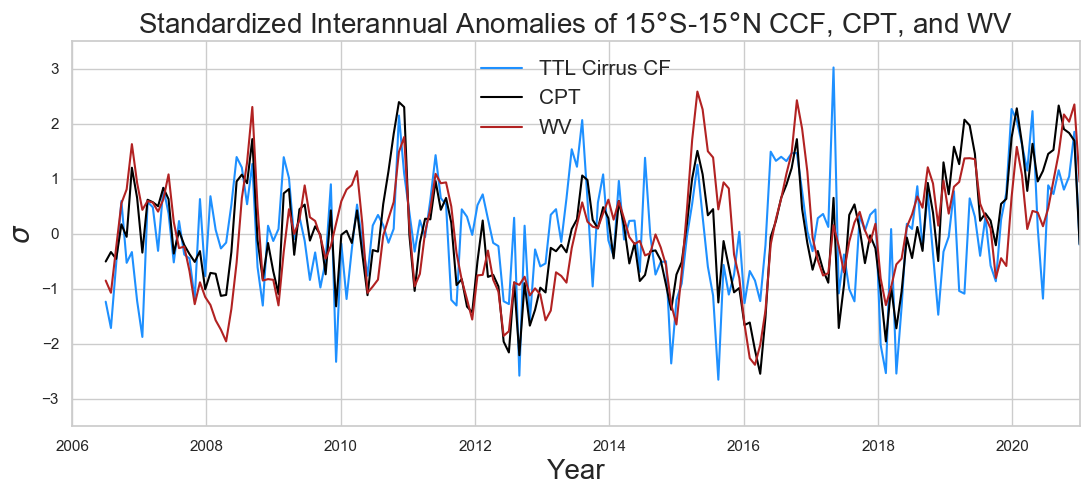

In [75]:
plt.figure(figsize=(13,5))
times = np.linspace(2006.5,2021,187)
plt.plot(times, ttl_cirrus_cf_ts*-1/np.nanstd(ttl_cirrus_cf_ts), label="TTL Cirrus CF", color='dodgerblue')
plt.plot(times, cpt_ts/np.nanstd(cpt_ts), label="CPT", color='Black')
plt.plot(times, wv_ts/np.nanstd(wv_ts), label="WV", color='firebrick')
plt.legend(frameon=False, fontsize=15)
plt.ylim(-3.5,3.5)
plt.xlim(2006,2021)
plt.ylabel('$\sigma$', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.title('Standardized Interannual Anomalies of 15$\degree$S-15$\degree$N CCF, CPT, and WV', fontsize=20)

# Correlation Matrix

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


\begin{tabular}{llllrr}
\toprule
        &       QBO  &       BDC  &      ENSO  &   R2 &  adj R2 \\
\midrule
  CPT   &  0.44/0.21 &  0.09/0.01 &  -0.43/0.2 & 0.61 &    0.60 \\
  CPZ   & -0.28/0.08 &   0.42/0.2 &  0.36/0.18 & 0.72 &    0.71 \\
   WV   &  0.54/0.31 &  0.33/0.11 & -0.24/0.05 & 0.58 &    0.57 \\
  TCF   & -0.22/0.06 &  0.18/0.05 &  0.37/0.18 & 0.53 &    0.52 \\
  ACF   & -0.26/0.09 & -0.03/0.11 &  0.31/0.12 & 0.37 &    0.35 \\
\bottomrule
\end{tabular}



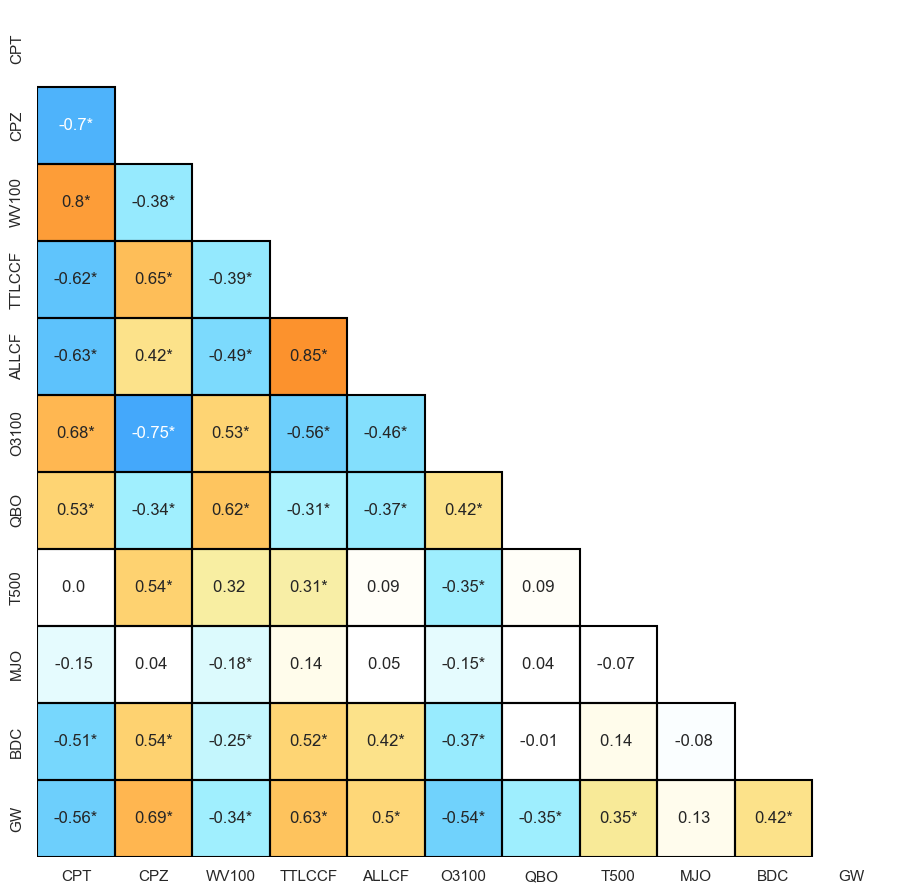

In [62]:
predictors_and_target = np.array([cpt_ts, cpz_ts, wv_ts, ttl_cirrus_cf_ts, allcfTCF_ts, o3_ts, qbo, T500, mjo, Trop_upwelling, gw_pe])

# Standardize predictors and targets so that coefficients in MLR model can be compared
predictors_and_target = [predictors_and_target[i]/np.nanstd(predictors_and_target[i]) for i in range(len(predictors_and_target))]
predictors_and_target_df = pd.DataFrame(np.transpose(predictors_and_target), columns=['CPT', 'CPZ', 'WV100', 'TTLCCF', 'ALLCF', 'O3100', 'QBO',
                                                                                      'T500', 'MJO', 'BDC', 'GW'])
# Create Correlation and Siginficance Matrices
corr_matrx = correlation_matrix_creator(predictors_and_target_df)

# Plot correlation Matrix
heatmap = corr_matrix_plotter(corr_matrx)
X = predictors_and_target_df[['QBO', 'T500', 'BDC', 'MJO', 'GW']]
Y1 = predictors_and_target_df['CPT']
Y2 = predictors_and_target_df['WV100']
Y3 = predictors_and_target_df['TTLCCF']
Y4 = predictors_and_target_df['ALLCF']
Y5 = predictors_and_target_df['CPZ']

lr_table(X, Y1, Y3, Y2, Y4, Y5)

#X1 = predictors_and_target_df[['BDC', 'QBO', 'T500', 'MJO']]
#lm = pg.linear_regression(X1, Y5, relimp=True)
#display(lm)

Text(0.5, 1.0, 'Explained Variance of Variables')

<Figure size 500x600 with 0 Axes>

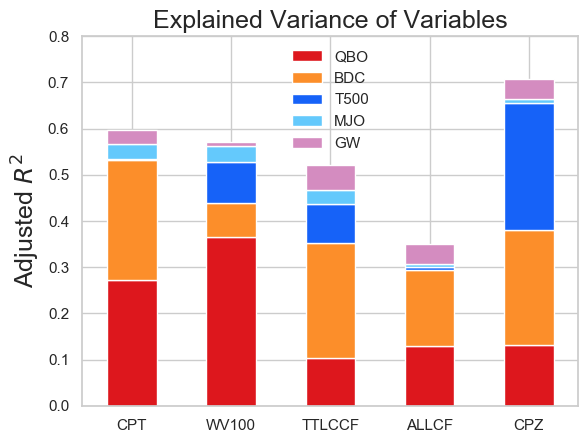

In [63]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Plot correlation Matrix
LSD = predictors_and_target_df[['QBO', 'BDC','T500', 'MJO']]
LSD_GW = predictors_and_target_df[['QBO', 'BDC','T500', 'MJO', 'GW']]
CPT = predictors_and_target_df['CPT']
CPZ = predictors_and_target_df['CPZ']
WV = predictors_and_target_df['WV100']
TTLCCF = predictors_and_target_df['TTLCCF']
AllCF = predictors_and_target_df['ALLCF']

targets = [CPT, WV, TTLCCF, AllCF, CPZ]
partitioned_variances = []
residual_targets = []
for TargetVariable in targets:
    lm = pg.linear_regression(LSD, TargetVariable, add_intercept=True, relimp=True)
    partitioned_adjr2 = lm.relimp_perc*lm.adj_r2[0]/100
    partitioned_adjr2 = partitioned_adjr2.to_list()
    partitioned_adjr2 = partitioned_adjr2[1:]
    LSDR2 = lm.adj_r2[0].astype(float)
    lm2 = pg.linear_regression(LSD_GW, TargetVariable, add_intercept=True, relimp=True)
    recreation = (lm2.coef[0] + LSD_GW.QBO*lm2.coef[1] + LSD_GW.BDC*lm2.coef[2] + LSD_GW.T500*lm2.coef[3] 
                  + LSD_GW.MJO*lm2.coef[4] + LSD_GW.GW*lm2.coef[5])
    residual = TargetVariable - recreation
    LSDGWR2 = lm2.adj_r2[0].astype(float)
    GW_partitioned_r2 = LSDGWR2 - LSDR2
    partitioned_adjr2.append(GW_partitioned_r2)
    partitioned_variances.append(partitioned_adjr2)
    residual_targets.append(residual)

partitioned_variances = pd.DataFrame(partitioned_variances, 
                                    index=['CPT', 'WV100', 'TTLCCF', 'ALLCF', 'CPZ'], 
                                    columns=['QBO', 'BDC', 'T500', 'MJO', 'GW'])

#barchart colors
bar_colors = np.array([(221,23,29),(252,142,42),(22,98,248),  (100,201,252), (212,140,192)])/255
sequential_colors = sns.color_palette(bar_colors, 5)

# set plot style: grey grid in the background:
sns.set(style="whitegrid")

# set the figure size
plt.figure(figsize=(5, 6))

# sum of total explained variance (equal to models R2)
total = np.nansum(partitioned_variances, axis=1,)

#create stacked bar chart
partitioned_variances.plot(kind='bar', stacked=True, color=sequential_colors, rot=0)
plt.legend(frameon=False,  )
plt.ylim(0,0.8)
plt.ylabel('Adjusted $R^{2}$', fontsize=18)
plt.title('Explained Variance of Variables', fontsize=18)

# Residual Timeseries

In [72]:
# The residual targets we want to predict
cpt_residual = residual_targets[0]
wv_residual = residual_targets[1]
tcf_residual = residual_targets[2]
acf_residual = residual_targets[3]
cpz_residual = residual_targets[4]

# also get global zonal mean temp anom data
temp_prof_anoms = temp_profs - np.nanmean(temp_profs, axis=0)
temp_prof_anoms_zm = np.nanmean(temp_prof_anoms, axis=3)
temp_profs_ts = np.reshape(temp_prof_anoms_zm, (16*12, 72, 350))
global_zm_temp_anoms = np.nanmean(np.reshape(temp_profs_ts, (192, 36,2,350)), axis=2)

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == "__main__":
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == "":


(350, 36)


Text(0.5, 0, 'Latitude')

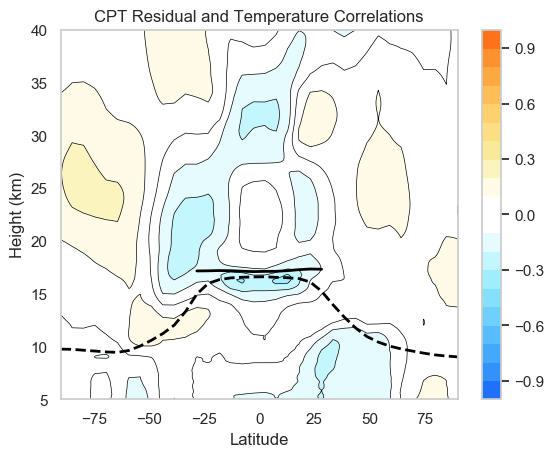

In [73]:
cpz_maps_zm_annual_mean = np.load(project_path + '/tempmaps/cpz_maps_zm_annual_mean.npy')
lrz_maps_zm_annual_mean = np.load(project_path + '/tempmaps/lrz_maps_zm_annual_mean.npy')

levels = np.linspace(-1,1,21)
corr_map = []
for x in range(len(global_zm_temp_anoms[0,:,0])):
    row = []
    for y in range(len(global_zm_temp_anoms[0,0,:])):
        temp_ts = global_zm_temp_anoms[5:,x,y]
        temps_ts_nonan = temp_ts[~np.isnan(temp_ts)]
        cpts_nonan = acf_residual[~np.isnan(temp_ts)]
        corr = stats.pearsonr(cpts_nonan, temps_ts_nonan)[0]
        row.append(corr)
    corr_map.append(row)
print(np.shape(np.transpose(corr_map)))
im = plt.contourf(np.linspace(-90,90,36), np.linspace(5,40,350), np.transpose(corr_map), levels=levels, cmap=custom_cmap)
plt.contour(np.linspace(-90,90,36), np.linspace(5,40,350), np.transpose(corr_map), levels=levels, cmap=custom_cmap)
plt.contour(np.linspace(-90,90,36), np.linspace(5,40,350), np.transpose(corr_map), levels=levels, colors='black', 
            linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
plt.plot(np.linspace(-90,90,36)[12:24], cpz_maps_zm_annual_mean[12:24], color='black', linewidth=2)
plt.plot(np.linspace(-90,90,36), lrz_maps_zm_annual_mean, color='black', linewidth=2, linestyle='dashed')
plt.colorbar(im)
plt.title('CPT Residual and Temperature Correlations')
plt.ylabel('Height (km)')
plt.xlabel('Latitude')


/home/disk/p/aodhan/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/disk/p/aodhan/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0.5, 1.0, 'Residual timeseries of CPT, WV82, and TTLCCF')

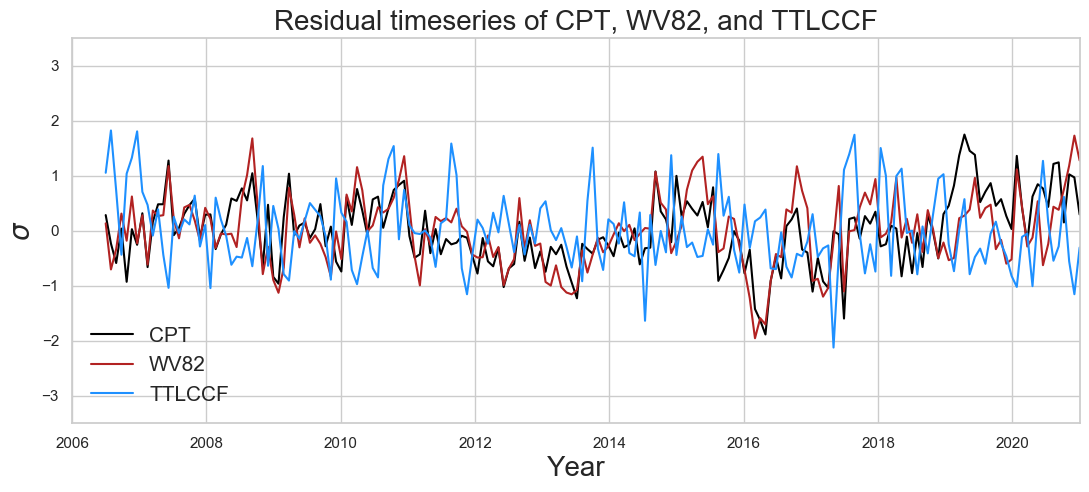

In [74]:
plt.figure(figsize=(13,5))
times = np.linspace(2006.5,2021,187)

    
plt.plot(times, cpt_residual, label="CPT ", color='black')
plt.plot(times, wv_residual, label="WV82", color='firebrick')
plt.plot(times, tcf_residual, label="TTLCCF", color='dodgerblue')

plt.legend(frameon=False, fontsize=15)
plt.ylim(-3.5,3.5)
plt.xlim(2006,2021)
plt.ylabel('$\sigma$', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.title('Residual timeseries of CPT, WV82, and TTLCCF', fontsize=20)

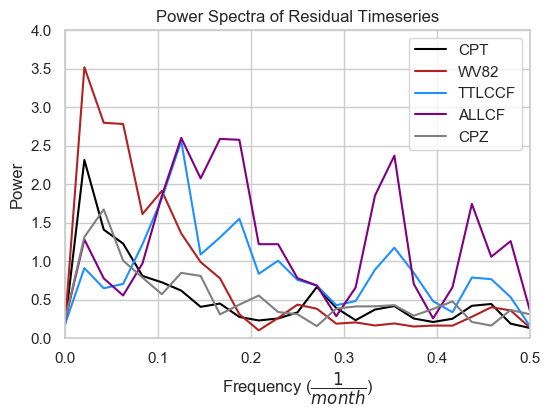

In [42]:
import scipy.signal as signal

# The residual targets we want to predict
cpt_residual = residual_targets[0]
wv_residual = residual_targets[1]
tcf_residual = residual_targets[2]
allcf_residual = residual_targets[3]
cpz_residual = residual_targets[4]

####################################
def power_spectra(timeseries):
    # Find Power Spectra
    chunk_length = 48

    # get DOF and autocorrelation
    dof = (2*len(timeseries[:])/chunk_length)*1.2
    f_crit = stats.f.ppf(q=1-0.05, dfn=dof, dfd=dof)
    alpha_stats = stats.pearsonr(timeseries[:-1], timeseries[1:])
    alpha = float(alpha_stats[0])

    #we need a red noise power spectrum so that we can scale it to find significance of peaks above the red noise
    red_noise_frequencies = np.linspace(0, np.pi, int(chunk_length/2)+1)
    red_noise = []
    red_noise = np.array([(1 - alpha*alpha)/(1 - 2*alpha*np.cos(freq) + alpha*alpha) for freq in red_noise_frequencies])

    # Find power spectra
    sample_frequencies, pow_spec_anom = signal.welch(timeseries[1:], fs=1.0, window='hamming', nperseg=chunk_length)
    total_power = np.sum(pow_spec_anom)
    total_red_power = np.sum(red_noise)
    power_ratio = total_power/total_red_power
    red_noise = red_noise*power_ratio
    return(sample_frequencies, pow_spec_anom, red_noise, f_crit)

sample_frequencies_cpt, pow_spec_anom_cpt, red_noise_cpt, f_crit_cpt = power_spectra(cpt_residual)
sample_frequencies_wv, pow_spec_anom_wv, red_noise_wv, f_crit_wv = power_spectra(wv_residual)
sample_frequencies_tcf, pow_spec_anom_tcf, red_noise_tcf, f_crit_tcf = power_spectra(tcf_residual)
sample_frequencies_acf, pow_spec_anom_acf, red_noise_acf, f_crit_acf = power_spectra(allcf_residual)
sample_frequencies_cpz, pow_spec_anom_cpz, red_noise_cpz, f_crit_cpz = power_spectra(cpz_residual)
plt.figure(figsize=(6, 4))
plt.plot(sample_frequencies_cpt, pow_spec_anom_cpt, color='black', label="CPT")
plt.plot(sample_frequencies_wv, pow_spec_anom_wv, color='firebrick', label="WV82")
plt.plot(sample_frequencies_tcf, pow_spec_anom_tcf, color='dodgerblue', label="TTLCCF")
plt.plot(sample_frequencies_acf, pow_spec_anom_acf, color='purple', label="ALLCF")
plt.plot(sample_frequencies_cpz, pow_spec_anom_cpz, color='grey', label='CPZ')
#plt.plot(sample_frequencies_wv, red_noise_wv*f_crit_wv, color='red', label='95% Red Noise')
#plt.plot(sample_frequencies_cpt, red_noise_cpt*f_crit_cpt, color='red', label='95% Red Noise')
plt.ylabel('Power')
plt.xlabel('Frequency ($\dfrac{1}{month}$)')
plt.title("Power Spectra of Residual Timeseries")
plt.ylim(0,4)
plt.xlim(0,0.5)
plt.legend()

